<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [2]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [3]:
# Load the data
house = pd.read_csv('./housing.csv')
pd.set_option('display.max_rows', house.shape[0]+1)
pd.set_option('display.max_columns', house.shape[1]+1)

In [4]:
house.info()
#MSSubClass is a list of categories, does not make sense to be in int64 form. Change to string
#LotFrontage should be correlated with LotArea,there are values missing where LotArea does not
#No alley access should be another category, so better to give it a value rather than NaN
#YearBuilt and YearRemodAdd, GarageYrBlt better be strings
#MasonryVeneerType, if NaN, should be changed to 'None'
#ExterCond and ExterQual are ordinal data and can be changed to int64. Same for any other cond and qual
#BasmtFinType# are ordinal data too
#BasmtSF# have no missing values, which indicates there are 0s
#HeatingQC are oridnal
#CentralAir can be changed to True/False
#one missing value in Electical
#PoolArea are all populated, can change the 0s to NaN
#MoSold and YrSold should be changed to strings


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [5]:
#Fixed feature that can predict the price are:
# all the numeric features excluding Overall condition and Overall quality, and saleprice
# the categorical feature that are not renovateable, include:
#'MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       #'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'BldgType',
       #'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       #'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       #'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'CentralAir',
       #'Electrical', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       #'GarageFinish', 'PavedDrive', 'Fence', 'MiscFeature', 'MoSold',
       #'YrSold', 'SaleType'

In [6]:
house.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [7]:
#LotFrontage should be correlated with LotArea,there are values missing where LotArea does not
house.LotFrontage.isnull().any()

True

In [8]:
#MSSubClass is a list of categories, does not make sense to be in int64 form. Change to string
house.MSSubClass = house.MSSubClass.astype(str)

In [9]:
house.MiscVal.replace(0,np.nan).count()

52

In [10]:
house.MiscFeature.value_counts()

Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

In [11]:
test = house[['MiscFeature','MiscVal']]

In [12]:
test.loc[test['MiscFeature'].notnull()]
#this is showing that there are 2 houses with misc features but no value attached. should be ok



,MiscFeature,MiscVal
5,Shed,700
7,Shed,350
16,Shed,700
17,Shed,500
51,Shed,400
84,Shed,700
95,Shed,480
98,Shed,400
99,Shed,400
106,Shed,450


In [13]:
#YearBuilt and YearRemodAdd, GarageYrBlt better be strings
#MoSold and YrSold should be changed to strings
house[['YearBuilt','YearRemodAdd','GarageYrBlt','MoSold','YrSold']] = house[['YearBuilt','YearRemodAdd','GarageYrBlt','MoSold','YrSold']].astype(str)

In [14]:
# There are houses with total bedroom area 0, which means it is not residential(assuming no bedrooms are in the basement), removing them
non_re = house.loc[house.BedroomAbvGr == 0].index

In [15]:
house.loc[house.BedroomAbvGr == 0]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
53,54,20,RL,68.0,50271,Pave,NaN,IR1,Low,AllPub,Inside,Gtl,Veenker,Norm,Norm,1Fam,1Story,9,5,1981,1987,Gable,WdShngl,WdShing,Wd Shng,None,0.0,Gd,TA,CBlock,Ex,TA,Gd,GLQ,1810,Unf,0,32,1842,GasA,Gd,Y,SBrkr,1842,0,0,1842,2,0,0,1,0,1,Gd,5,Typ,1,Gd,Attchd,1981.0,Fin,3,894,TA,TA,Y,857,72,0,0,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal,385000
189,190,120,RL,41.0,4923,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,2001,2002,Gable,CompShg,CemntBd,CmentBd,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1153,Unf,0,440,1593,GasA,Ex,Y,SBrkr,1593,0,0,1593,1,0,1,1,0,1,Ex,5,Typ,1,Gd,Attchd,2001.0,Fin,2,682,TA,TA,Y,0,120,0,0,224,0,NaN,NaN,NaN,0,8,2008,WD,Normal,286000
634,635,90,RL,64.0,6979,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,Duplex,SFoyer,6,5,1980,1980,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,GLQ,1056,Unf,0,0,1056,GasA,Gd,Y,SBrkr,1056,0,0,1056,2,0,0,0,0,2,TA,4,Typ,0,NaN,Detchd,1980.0,Unf,2,576,TA,TA,Y,264,56,0,0,0,0,NaN,GdPrv,Shed,600,6,2010,WD,Normal,144000
1163,1164,90,RL,60.0,12900,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Feedr,Norm,Duplex,SFoyer,4,4,1969,1969,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,Av,GLQ,1198,Unf,0,0,1198,GasA,TA,Y,SBrkr,1258,0,0,1258,2,0,0,2,0,2,TA,6,Typ,0,NaN,CarPort,1969.0,Unf,2,400,Fa,TA,Y,120,0,0,0,0,0,NaN,NaN,NaN,0,1,2008,WD,Alloca,108959
1213,1214,80,RL,NaN,10246,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,Norm,Norm,1Fam,SLvl,4,9,1965,2001,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,Gd,Av,GLQ,648,Unf,0,0,648,GasA,Ex,Y,SBrkr,960,0,0,960,1,1,0,0,0,1,TA,3,Typ,0,NaN,Attchd,1965.0,Unf,1,364,TA,TA,Y,88,0,0,0,0,0,NaN,NaN,NaN,0,5,2006,WD,Normal,145000
1270,1271,40,RL,NaN,23595,Pave,NaN,Reg,Low,AllPub,Inside,Sev,ClearCr,Norm,Norm,1Fam,1Story,7,6,1979,1979,Shed,WdShake,Plywood,Plywood,None,0.0,Gd,TA,PConc,Gd,TA,Gd,GLQ,1258,Unf,0,74,1332,GasA,TA,Y,SBrkr,1332,192,0,1524,2,0,0,1,0,1,Gd,4,Typ,1,TA,Attchd,1979.0,Fin,2,586,TA,TA,Y,268,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,260000


In [16]:
ho = house.drop(non_re)

In [17]:
#Fill NaN of numerical columns with the median of the column
ho = ho.fillna(ho.median())

In [18]:
#Fill the remaining NaN with another category 'None'
ho = ho.fillna('None')

In [19]:
ho.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000


In [555]:
ho_num = ho.select_dtypes(exclude='O')

#filtering out the Quality and Condition columns from numerical features
QCmask = np.frompyfunc(lambda x: any(r in x for r in ['Qu','Cond','QC','Price']), 1, 1)(ho_num.columns)
fixed_col_num = ho_num.columns[np.logical_not(QCmask)]

ho_ob = ho.select_dtypes('O')

#filtering out the Quality and Condition columns from categorical features
QCmask = np.frompyfunc(lambda x: any(r in x for r in ['Qu','Cond','QC','FinType','Finish']) and ('Condition' not in x), 1, 1)(ho_ob.columns)
fixed_col_ob = ho_ob.columns[np.logical_not(QCmask)]

(array([573.,  58., 217., 173.,  97., 226.,  79.,  22.,   6.,   3.]),
 array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ]),
 <a list of 10 Patch objects>)

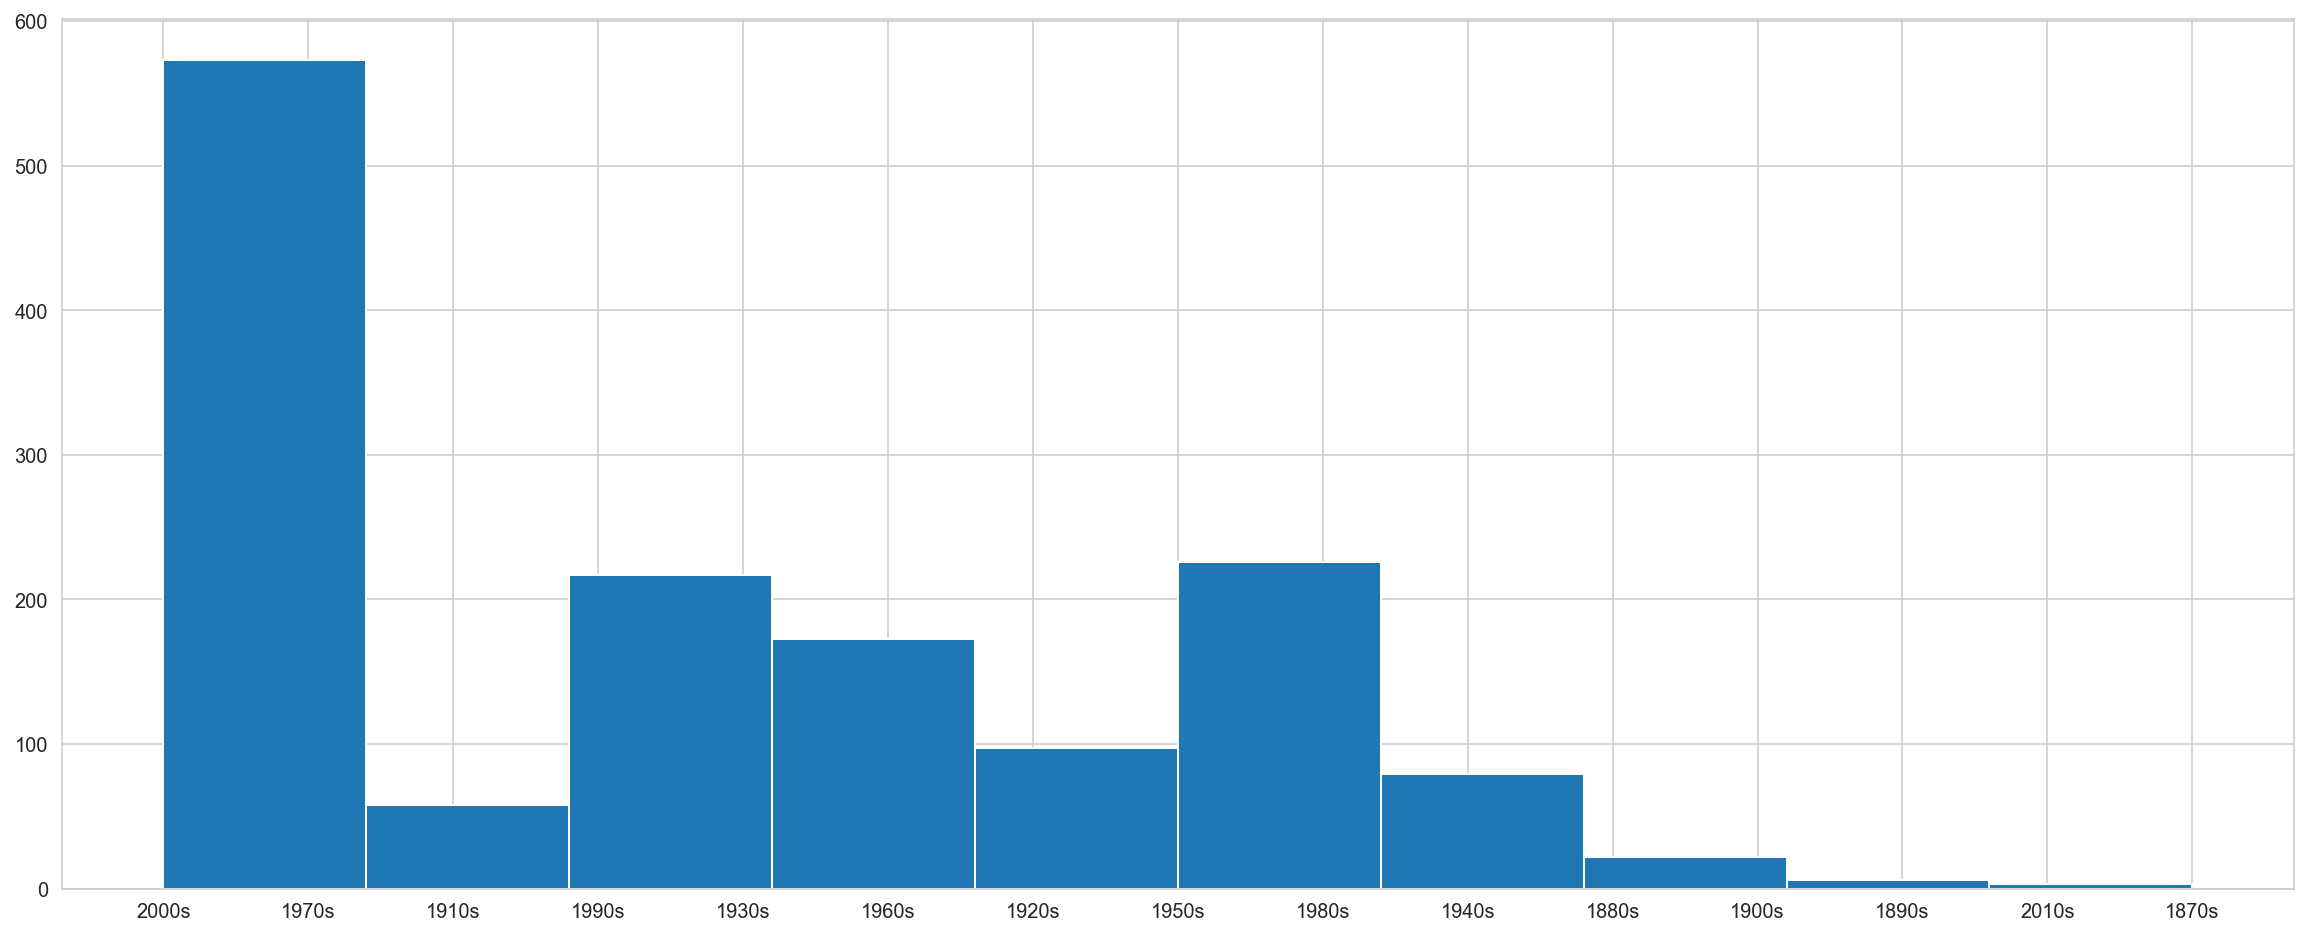

In [556]:
#year built has way too many categories to OneHotEncode, need to put them into ranges
plt.subplots(figsize = (20,8))
plt.hist(ho.YearBuilt)

In [557]:
ho.groupby('YearBuilt')['YearBuilt'].agg('count')

YearBuilt
1870s      2
1880s      7
1890s      6
1900s     15
1910s     58
1920s     97
1930s     54
1940s     79
1950s    167
1960s    173
1970s    187
1980s     59
1990s    163
2000s    386
2010s      1
Name: YearBuilt, dtype: int64

In [558]:
def yearcat(year):
    return year[:3]+'0s'

In [559]:
ho['YearBuilt'] = ho.YearBuilt.map(yearcat)

In [560]:
ho['YearRemodAdd'] = ho.YearRemodAdd.map(yearcat)

In [561]:
#creating a list of columns with fixed features
fixed_col = list(fixed_col_num)+list(fixed_col_ob)

ho_fix = ho[fixed_col]

In [562]:

ho.YrSold.max()

'2010'

In [590]:
Yrmask = ho.YrSold.astype('int')==2010

In [591]:
X = pd.get_dummies(ho_fix)

y = ho.SalePrice

X_train = X[~Yrmask]

X_test = X[Yrmask]

y_train = y[~Yrmask]

y_test = y[Yrmask]

In [592]:

#elsatic net takes care of multicollinearity, removes correlated features. after tweaking I find that a ratio closer to l1 works the best
from sklearn.linear_model import ElasticNet
regr = ElasticNet(random_state=0,l1_ratio=0.9)
regr.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 762669725032.3848, tolerance: 802024093.96932
  positive)


ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.9,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=0, selection='cyclic', tol=0.0001, warm_start=False)

In [593]:
#Testing against post 2008 data,looks pretty good
regr.score(X_test,y_test)

0.8611093250413393

In [594]:
np.where(regr.coef_ > regr.coef_.std()*3)[0]

array([ 19,  86,  87,  98, 146, 204, 228], dtype=int64)

In [595]:
# getting the top and bottom vaules
maxindex = np.where(np.abs(regr.coef_) > regr.coef_.std()*3)

a = regr.coef_[maxindex].tolist()

b = X.columns[maxindex].tolist()


estimators = pd.DataFrame({'Estimator':b,'Coefficient':a})



In [596]:
a = regr.coef_[maxindex].tolist()

In [597]:
b = X.columns[maxindex].tolist()

In [598]:

estimators = pd.DataFrame({'Estimator':b,'Coefficient':a})

In [599]:
resulte = estimators.sort_values('Coefficient',ascending = False).set_index('Estimator')

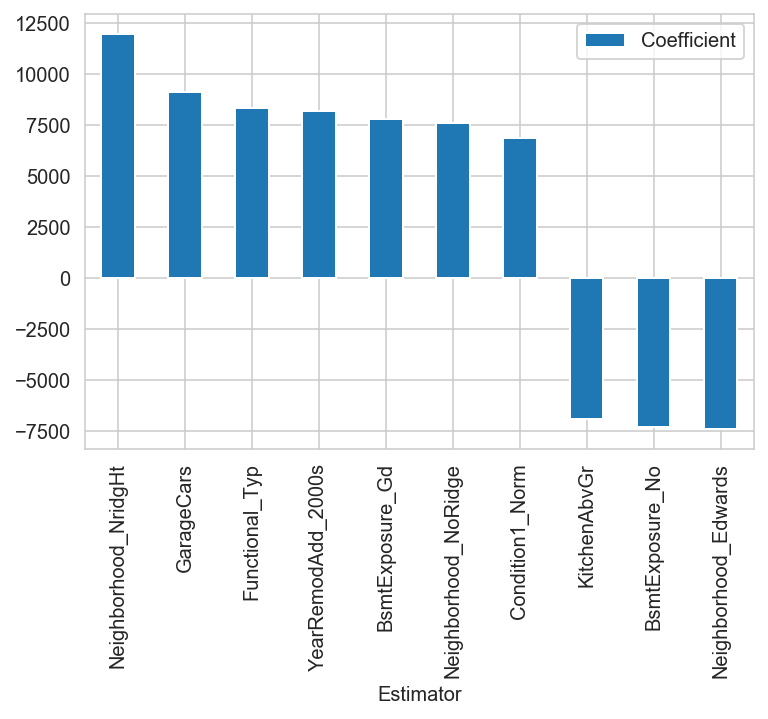

In [600]:
resulte.plot(kind='bar')

In [620]:
resulte

,Coefficient
Estimator,
Neighborhood_NridgHt,11974.866571
GarageCars,9097.741143
Functional_Typ,8336.602439
YearRemodAdd_2000s,8185.738985
BsmtExposure_Gd,7791.543398
Neighborhood_NoRidge,7597.487358
Condition1_Norm,6849.447956
KitchenAbvGr,-6911.997385
BsmtExposure_No,-7289.921279


In [633]:
#another way to look at estimator is to calculate the actual values times the coefficients, since the coefficients may be small for some very large numbers, but still contribute to the overall output
X_weight = regr.coef_ * X

In [634]:
topest = X_weight.max().sort_values(ascending=False)[:10]

In [635]:
botest = X_weight.max().sort_values(ascending=True)[:5]

In [639]:
topest

GrLivArea      160512.999905
1stFlrSF       134498.011534
BsmtFinSF1     105692.678464
2ndFlrSF        76079.033166
MasVnrArea      66498.547253
LotArea         40823.510368
GarageCars      36390.964570
TotalBsmtSF     35765.289291
GarageArea      30359.013048
ScreenPorch     27539.222949
dtype: float64

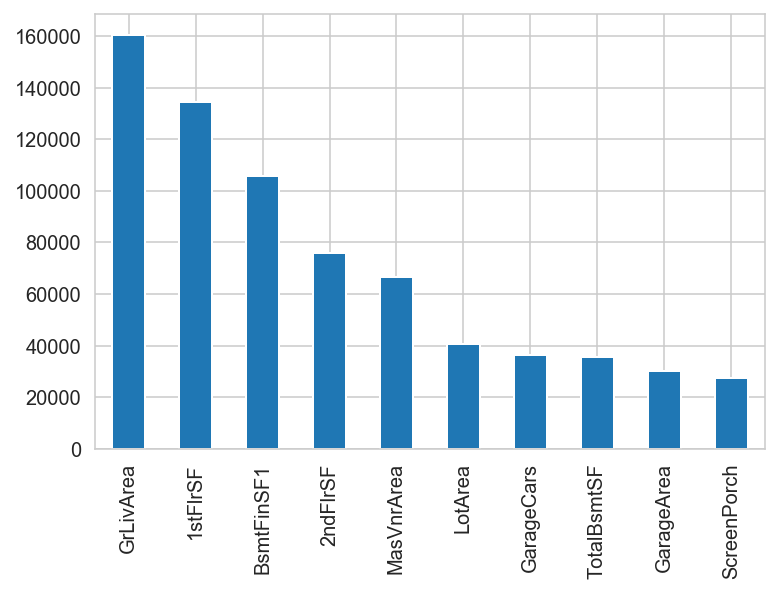

In [638]:
topest.plot(kind = 'bar')

In [632]:
botest

BedroomAbvGr      -5280.502835
LotFrontage       -1663.111796
Id                   -2.989153
Functional_Maj1      -0.000000
Electrical_Mix       -0.000000
dtype: float64

In [640]:
# Neighborhood is the best estimator, highest reward for good area, highest penalty for bad area
# size of living area on ground floor is a good indicator of price

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [603]:
ho_num = ho.select_dtypes(exclude='O')

#choosing the Quality and Condition columns from numerical features
QCmask = np.frompyfunc(lambda x: any(r in x for r in ['Qu','Cond','QC']), 1, 1)(ho_num.columns)
fixed_col_num = ho_num.columns[QCmask]

ho_ob = ho.select_dtypes('O')

#choosing the Quality and Condition columns from categorical features
QCmask = np.frompyfunc(lambda x: any(r in x for r in ['Qu','Cond','QC','FinType','Finish']) and ('Condition' not in x), 1, 1)(ho_ob.columns)
fixed_col_ob = ho_ob.columns[QCmask]

In [604]:
# A:
#creating a list of columns with fixed features
fixed_col = list(fixed_col_num)+list(fixed_col_ob)

ho_fix = ho[fixed_col]

In [605]:
ho_fix.head()

,OverallQual,OverallCond,LowQualFinSF,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,FireplaceQu,GarageFinish,GarageQual,GarageCond,PoolQC
0,7,5,0,Gd,TA,Gd,TA,GLQ,Unf,Ex,Gd,None,RFn,TA,TA,None
1,6,8,0,TA,TA,Gd,TA,ALQ,Unf,Ex,TA,TA,RFn,TA,TA,None
2,7,5,0,Gd,TA,Gd,TA,GLQ,Unf,Ex,Gd,TA,RFn,TA,TA,None
3,7,5,0,TA,TA,TA,Gd,ALQ,Unf,Gd,Gd,Gd,Unf,TA,TA,None
4,8,5,0,Gd,TA,Gd,TA,GLQ,Unf,Ex,Gd,TA,RFn,TA,TA,None


In [606]:
# taking the entire feature space into the fixed asset model,predicting the result and calculate the residual against actual price
yf = regr.predict(X)
yre = y - yf

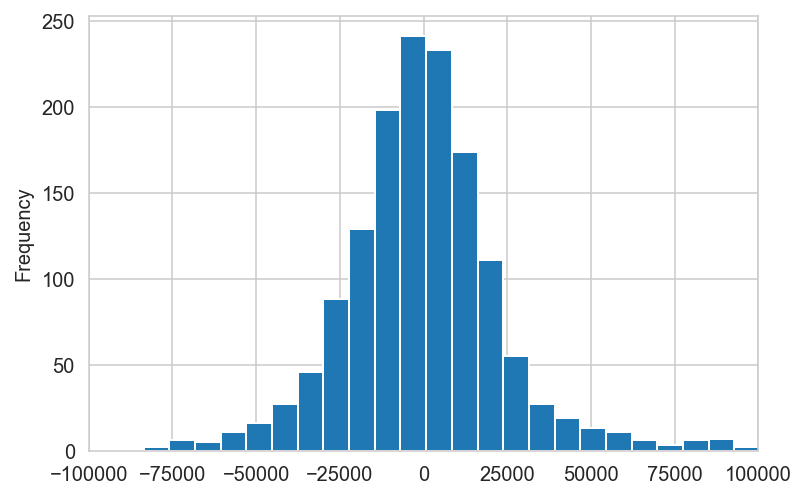

In [607]:
# the residuals are normally distributed
yre.plot(kind= 'hist',bins = 100,xlim = (-100000,100000))

In [608]:

Xre = pd.get_dummies(ho_fix)

In [609]:
Xre.head()

,OverallQual,OverallCond,LowQualFinSF,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_None
0,7,5,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
1,6,8,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
2,7,5,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
3,7,5,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
4,8,5,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1


In [615]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNetCV
ela = ElasticNetCV(random_state=0,l1_ratio=1,cv = 5)


In [616]:
cross_val_score(ela,Xre,yre)

array([0.19196553, 0.06890248, 0.1892659 , 0.22186024, 0.07525108])

In [617]:
ela.fit(Xre,yre)

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
             l1_ratio=1, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto', random_state=0,
             selection='cyclic', tol=0.0001, verbose=0)

In [618]:
# getting the top and bottom vaules
maxindex = np.where(np.abs(ela.coef_) > ela.coef_.std()*3)

a = ela.coef_[maxindex].tolist()

b = Xre.columns[maxindex].tolist()


estimators = pd.DataFrame({'Estimator':b,'Coefficient':a})

estimators.sort_values('Coefficient',ascending = False).set_index('Estimator')

,Coefficient
Estimator,
KitchenQual_Ex,16667.505559
BsmtQual_Ex,9765.787699


In [619]:
# the above 2 factors are the renovations the company should be focusing on
# the model isn't very fitting but the estimators are indicative enough to point out the features to renovate
# the company can make money by buying a poor quality house with the desired features listed in the first model, and renovate the kitchen and basement to sell for profit

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [531]:
# A:
yc = ho.SaleCondition


In [515]:
from sklearn.preprocessing import LabelEncoder

In [493]:
yc.value_counts()

Normal     1193
Partial     125
Abnorml     101
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

In [526]:
yc = LabelEncoder().fit_transform(yc).astype('O')

In [495]:
yc.head()

,Abnorml,AdjLand,Alloca,Family,Normal,Partial
0,0,0,0,0,1,0
1,0,0,0,0,1,0
2,0,0,0,0,1,0
3,1,0,0,0,0,0
4,0,0,0,0,1,0


In [517]:
yc

0        Normal
1        Normal
2        Normal
3       Abnorml
4        Normal
5        Normal
6        Normal
7        Normal
8       Abnorml
9        Normal
10       Normal
11      Partial
12       Normal
13      Partial
14       Normal
15       Normal
16       Normal
17       Normal
18       Normal
19      Abnorml
20      Partial
21       Normal
22       Normal
23       Normal
24       Normal
25       Normal
26       Normal
27       Normal
28       Normal
29       Normal
30       Normal
31       Normal
32       Normal
33       Normal
34       Normal
35       Normal
36       Normal
37       Normal
38      Abnorml
39      AdjLand
40      Abnorml
41       Normal
42       Normal
43       Normal
44       Normal
45       Normal
46      Abnorml
47       Normal
48      Partial
49       Normal
50       Normal
51       Normal
52       Normal
54       Normal
55       Normal
56      Abnorml
57       Normal
58      Partial
59       Normal
60      Partial
61       Normal
62       Normal
63      

In [483]:
X = ho.drop('SaleCondition',axis = 1)

In [485]:
X = pd.get_dummies(X)

In [486]:
X.head()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,...,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_None,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,1,65.0,8450,7,5,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,208500,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,2,80.0,9600,6,8,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0,181500,0,0,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,3,68.0,11250,7,5,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2,608,0,42,0,0,0,0,0,223500,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,4,60.0,9550,7,5,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,3,642,0,35,272,0,0,0,0,140000,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,5,84.0,14260,8,5,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,3,836,192,84,0,0,0,0,0,250000,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [506]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import MinMaxScaler

In [528]:
#choosing strong l1 penalty, which works best with imbalanced class, only saga solver support
model=LogisticRegression(penalty='l1', C= 0.1,random_state = 0,solver = 'saga')

array([4, 4, 4, ..., 4, 4, 4], dtype=object)

In [503]:
#choosing strong l1 penalty, which works best with imbalanced class, only saga solver support
logr = LogisticRegression(penalty='l1', C= 0.1,random_state = 0,solver = 'saga')

In [532]:
cross_val_score(model, X, yc, cv=5)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the

array([0.82130584, 0.82130584, 0.82130584, 0.81786942, 0.82068966])

In [533]:
model.fit(X,yc)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=0, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [540]:
result = model.predict(X)

In [544]:
np.unique(result,return_counts=True)

(array(['Normal'], dtype=object), array([1454], dtype=int64))

In [545]:
# Indeed, 'Normal' will dominate the prediction because of class imbalance

In [ ]:
Xre